In [2]:
import yfinance as yf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


In [3]:
aapl = yf.download('aapl',start = '2000-01-01',end = '2023-08-25')
vix = yf.download('^VIX',start = '2000-01-01',end = '2023-08-25')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
tf.test.gpu_device_name()

2023-09-05 21:42:02.338980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-05 21:42:02.365742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-05 21:42:02.365875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

'/device:GPU:0'

In [5]:
tf.__version__

'2.12.0'

In [6]:
aapl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.848323,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.776801,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.788168,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.719961,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.754065,460734400


In [7]:
aapl['Vix'] = vix['High']

In [8]:
aapl['HighCHG'] = aapl['High'].pct_change() * 100
aapl['HighCHG'].fillna(0, inplace=True)
aapl.head()

aapl['CloseCHG'] = aapl['High'].pct_change() * 100
aapl['CloseCHG'].fillna(0, inplace=True)
aapl.head()

aapl['VolumeCHG'] = aapl['Volume'].pct_change() * 100
aapl['VolumeCHG'].fillna(0, inplace=True)
aapl.head()

aapl['VixCHG'] = aapl['Vix'].pct_change() * 100
aapl['VixCHG'].fillna(0, inplace=True)
aapl.head()

,Open,High,Low,Close,Adj Close,Volume,Vix,HighCHG,CloseCHG,VolumeCHG,VixCHG
Date,,,,,,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.848323,535796800,26.150000,0.000000,0.000000,0.000000,0.000000
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.776801,512377600,27.180000,-1.666664,-1.666664,-4.370911,3.938817
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.788168,778321600,29.000000,-0.056495,-0.056495,51.903908,6.696099
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.719961,767972800,26.709999,-3.222152,-3.222152,-1.329630,-7.896555
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.754065,460734400,25.170000,-5.607431,-5.607431,-40.006417,-5.765627


In [9]:
def train_test_split(dataset, tstart, tend, feature_list):
    train = dataset.loc[f"{tstart}":f"{tend}", feature_list].values
    test = dataset.loc[f"{tend+1}":, feature_list].values
    
    return train, test

In [10]:
tstart = 2010
tend = 2021
# feature_list = ['High','Volume','Vix','HighCHG','VolumeCHG','VixCHG']
# feature_list = ['Close']

feature_list = ['Close','CloseCHG','Volume','High']
training_set, test_set = train_test_split(aapl,tstart, tend, feature_list)


In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [64]:
# training_set = training_set.reshape(-1,1)
training_set_scaled = scaler.fit_transform(training_set)
training_set_scaled.shape

(3021, 4)

In [65]:
def split_sequence(sequence, n_steps):
    X, y = [], [] 
    for i in range(len(sequence)):
        end_idx = i + n_steps
        if end_idx > len(sequence) - 1: 
            break
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx][0:1]
        X.append(seq_x)
        y.append(seq_y) 
    return np.array(X), np.array(y)

In [66]:
n_steps = 3
features = 4

X_train, y_train = split_sequence(training_set_scaled, n_steps)
X_train

array([[[ 0.00681329, -0.99095774, -0.50790207, -0.99245459],
        [ 0.00373932, -0.99080539, -0.39032021, -0.99201001],
        [-0.06353391, -0.99220949, -0.4443907 , -0.99215684]],

       [[ 0.00373932, -0.99080539, -0.39032021, -0.99201001],
        [-0.06353391, -0.99220949, -0.4443907 , -0.99215684],
        [-0.19643146, -0.99237009, -0.52594383, -0.99347423]],

       [[-0.06353391, -0.99220949, -0.4443907 , -0.99215684],
        [-0.19643146, -0.99237009, -0.52594383, -0.99347423],
        [-0.04689546, -0.99179362, -0.55803126, -0.99347423]],

       ...,

       [[ 0.00919844,  0.9533063 , -0.97026453,  0.93970195],
        [ 0.15424863,  1.        , -0.96313083,  0.98047157],
        [ 0.00336235,  0.98800943, -0.95853876,  0.9908639 ]],

       [[ 0.15424863,  1.        , -0.96313083,  0.98047157],
        [ 0.00336235,  0.98800943, -0.95853876,  0.9908639 ],
        [-0.08536098,  0.9890472 , -0.97679465,  0.98286987]],

       [[ 0.00336235,  0.98800943, -0.95853876,

In [67]:
display(X_train.shape)
display(y_train)

(3018, 3, 4)

array([[-1.96431464e-01],
       [-4.68954629e-02],
       [ 1.05588998e-04],
       ...,
       [-8.53609810e-02],
       [-5.02051641e-02],
       [-1.20840333e-01]])

In [68]:
# X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], features)

In [69]:
y_train.shape

(3018, 1)

In [70]:
model_lstm = Sequential()
model_lstm.add(LSTM(units = 150, activation='tanh', input_shape=(None,features),return_sequences=True))
model_lstm.add(Dropout(.2))
model_lstm.add(LSTM(units = 150, activation='tanh', input_shape=(None,features),return_sequences=True))
model_lstm.add(Dropout(.2))
model_lstm.add(LSTM(units = 50, activation='tanh', input_shape=(None,features)))
model_lstm.add(Dropout(.2))
model_lstm.add(Dense(units = 1))
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()


# model_lstm = Sequential()
# model_lstm.add(LSTM(units = 125, activation='tanh', input_shape=(None,features),))
# model_lstm.add(Dense(units = 1))
# model_lstm.compile(optimizer="RMSprop", loss="mse")

# model_lstm.summary()

2023-09-05 21:52:20.697812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-05 21:52:20.698851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-05 21:52:20.699571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, None, 150)         93000     
                                                                 
 dropout_9 (Dropout)         (None, None, 150)         0         
                                                                 
 lstm_10 (LSTM)              (None, None, 150)         180600    
                                                                 
 dropout_10 (Dropout)        (None, None, 150)         0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                40200     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

2023-09-05 21:52:20.941116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-05 21:52:20.942153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-05 21:52:20.942942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [71]:
import time

In [72]:
timeStart = time.time()
model_lstm.fit(X_train,y_train,batch_size=30, epochs=100)
timeEnd = time.time()

Epoch 1/100


2023-09-05 21:52:28.413110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-05 21:52:28.414304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-05 21:52:28.415349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

101/101 [==============================] - 3s 3ms/step - loss: 0.0224
Epoch 2/100
101/101 [==============================] - 0s 3ms/step - loss: 0.0223
Epoch 3/100
101/101 [==============================] - 0s 3ms/step - loss: 0.0224
Epoch 4/100
101/101 [==============================] - 0s 3ms/step - loss: 0.0222
Epoch 5/100
101/101 [==============================] - 0s 3ms/step - loss: 0.0223
Epoch 6/100
101/101 [==============================] - 0s 3ms/step - loss: 0.0222
Epoch 7/100
101/101 [==============================] - 0s 3ms/step - loss: 0.0222
Epoch 8/100
101/101 [==============================] - 0s 3ms/step - loss: 0.0222
Epoch 9/100
101/101 [==============================] - 0s 3ms/step - loss: 0.0223
Epoch 10/100
101/101 [==============================] - 0s 4ms/step - loss: 0.0223
Epoch 11/100
101/101 [==============================] - 0s 3ms/step - loss: 0.0222
Epoch 12/100
101/101 [==============================] - 0s 3ms/step - loss: 0.0222
Epoch 13/100
101/101 [===

In [60]:
timeEnd - timeStart

37.82751512527466

In [61]:
dataset_total = aapl.loc[:,feature_list]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values

# inputs = inputs.reshape(-1, 1)
#scaling
inputs = scaler.transform(inputs)
# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)

# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)

padded_predictions = np.zeros((predicted_stock_price.shape[0], features))

padded_predictions[:, 0] = predicted_stock_price.squeeze() 
inverse_transformed_predictions = scaler.inverse_transform(padded_predictions)
final_predictions = inverse_transformed_predictions[:, 0]



2023-09-05 21:50:09.243309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-05 21:50:09.244264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-05 21:50:09.245118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 1s 2ms/step


2023-09-05 21:50:09.470980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-05 21:50:09.472026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-05 21:50:09.472838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [62]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))


In [73]:
y_test

array([[ 1.56026178e-01],
       [-4.36264814e-02],
       [-1.97770318e-01],
       [-3.16229449e-01],
       [-1.12831455e-01],
       [-1.40735950e-01],
       [ 1.07911188e-01],
       [ 6.68648030e-02],
       [-7.83886462e-02],
       [-2.07117784e-01],
       [-1.17995352e-01],
       [-1.31210618e-01],
       [-1.28436595e-01],
       [-2.43619800e-01],
       [-2.88318900e-01],
       [-1.86547053e-02],
       [ 5.28943816e-02],
       [-8.02330998e-02],
       [ 3.49023969e-01],
       [ 2.25096040e-01],
       [-5.60058531e-02],
       [ 1.23753967e-02],
       [-2.65000794e-02],
       [-1.67886795e-01],
       [-5.54809331e-02],
       [ 3.33003247e-02],
       [ 2.69763225e-02],
       [-1.12891318e-01],
       [-1.83174052e-01],
       [-2.48391384e-01],
       [ 1.51120291e-01],
       [-2.44262181e-02],
       [-1.29097037e-01],
       [-1.26304113e-01],
       [-2.71841611e-01],
       [-7.91756605e-02],
       [-2.44800620e-01],
       [ 9.19977688e-02],
       [-2.8

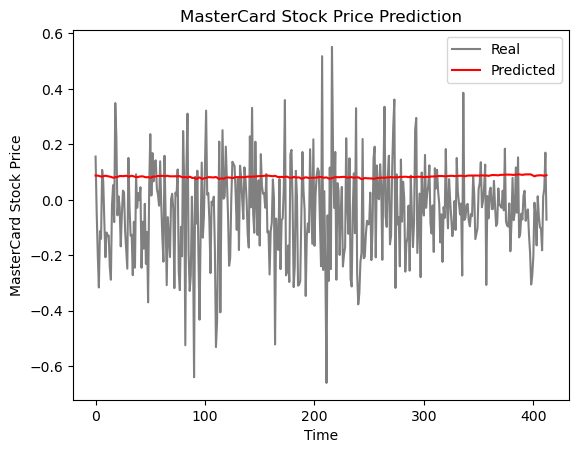

In [74]:
# test_set[:,0]
plot_predictions(y_test[:,0],final_predictions)

In [50]:
results = pd.DataFrame(test_set[:,0], final_predictions)
results = results.reset_index()
results.columns = ['predicted', 'real']

# results['predicted_change'] = results['predicted'].pct_change() * 100
# results['real_change'] = results['real'].pct_change() * 100
# aapl['HighCHG'].fillna(0, inplace=True)

In [47]:
results

,predicted,real,predicted_change,real_change
0,-0.006944,2.036495,NaN,NaN
1,0.240080,0.032807,-3557.372854,-98.389042
2,0.046009,-1.514160,-80.835851,-4715.347488
3,-0.101608,-2.703000,-320.842974,78.514827
4,-0.205809,-0.661725,102.551904,-75.518874
...,...,...,...,...
408,0.003415,-1.357663,-82.773228,135.337397
409,-0.058986,0.588235,-1827.315290,-143.326979
410,0.131098,0.880025,-322.253243,49.604405
411,0.159260,2.178079,21.481902,147.501976


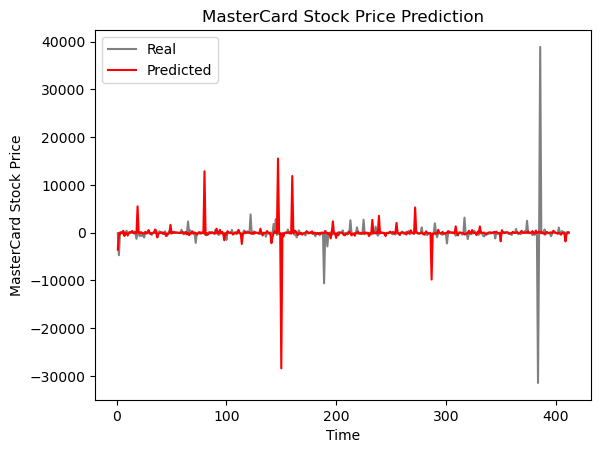

In [48]:
plot_predictions(results['real_change'],results['predicted_change'])

In [51]:
results['same'] = ((results['predicted'] > 0) & (results['real'] > 0)) | ((results['predicted'] < 0) & (results['real'] < 0))
results['same'].sum() / len(results) * 100

56.416464891041166

In [ ]:
results.describe()

In [ ]:
import seaborn as sns

In [ ]:
sns.scatterplot(results['predicted_change'])

In [ ]:
thresh = 1

In [ ]:
largeMove = results[abs(results['predicted_change']) > thresh]

In [ ]:
largeMove['difference'] = largeMove['predicted_change'] - largeMove['real_change']

In [ ]:
sns.scatterplot(largeMove['difference'])

In [ ]:
results['same'] = ((results['predicted_change'] > 0) & (results['real_change'] > 0)) | ((results['predicted_change'] < 0) & (results['real_change'] < 0))
results['same'].sum() / len(results) * 100